In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as ms

#Librerias antes no vistas
from scipy import stats
from scipy.stats import norm, skew


pd.set_option('display.max_columns',None)


In [ ]:
train=pd.read_csv('https://raw.githubusercontent.com/HackSpacePeru/Datasets_intro_Data_Science/master/House_pricing/train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/HackSpacePeru/Datasets_intro_Data_Science/master/House_pricing/test.csv')

# Presentacion del dataset Housing Price California

In [ ]:
print('Para la data de train:', train.shape)
print('Para la data de test:',test.shape)

In [ ]:
train.head()

In [ ]:
test.head()

In [ ]:
ms.matrix(train)

In [ ]:
ms.matrix(test)

In [ ]:
train.drop("Id", axis = 1, inplace = True)
test.drop("Id",axis=1,inplace=True)

### Limpiando Nulos

- Nulos categoricos.

- Nulos numéricos.

In [ ]:
columnas_object_nulos = [col for col in test.columns if ((train[col].dtype =='object')|(test[col].dtype == 'object')&((train[col].isna().any()|(test[col].isna().any()))))]

In [ ]:
def reemplazando_non_nans(df, lista_cols_obj_nulos):
    for col in lista_cols_obj_nulos:
        df[col].fillna("None",inplace=True)

In [ ]:
reemplazando_non_nans(train,columnas_object_nulos)
reemplazando_non_nans(test,columnas_object_nulos)

In [ ]:
for col in ['BsmtFinSF2','BsmtFullBath','BsmtHalfBath','GarageCars']:
    train.loc[train[col].isna(),col] = 0.0
    test.loc[test[col].isna(),col] = 0

In [ ]:
lista_nulos_numericos = [col for col in test.columns if (test[col].isna().any())]

In [ ]:
for col in lista_nulos_numericos:
    plt.title(train[col].isna().sum())
    sns.distplot(train[col].dropna())
    plt.show()

In [ ]:
for col in lista_nulos_numericos:
    plt.title(test[col].isna().sum())
    sns.distplot(test[col].dropna())
    plt.show()

In [ ]:
for col in lista_nulos_numericos:
    train[col].fillna(train[col].mean(),inplace=True)
    test[col].fillna(test[col].mean(),inplace=True)

### Exportando a csv

In [ ]:
train.to_csv('train_limpio.csv',index=False)
test.to_csv('test_limpio.csv',index=False)

In [28]:
train = pd.read_csv('train_limpio.csv')
summit = pd.read_csv('test_limpio.csv')

# Procesamiento de Datos

##### OUTLIERS

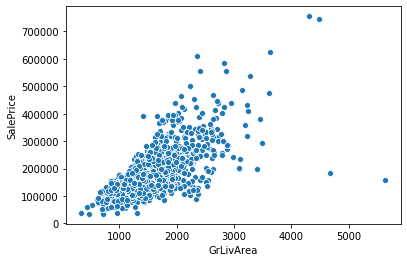

In [29]:
sns.scatterplot(x = train['GrLivArea'], y = train['SalePrice'])

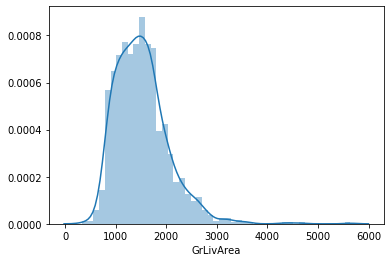

In [30]:
sns.distplot(train['GrLivArea'])

In [31]:
dict_outliers = {}
for col in train.columns:
    if train[col].dtype != 'object':        
        if train[col].kurt() > 20:
            dict_outliers[col] = train[col].kurt()
    else:
        pass

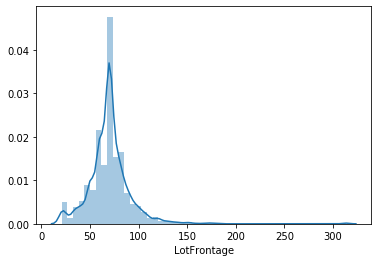

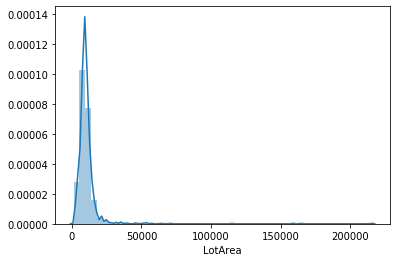

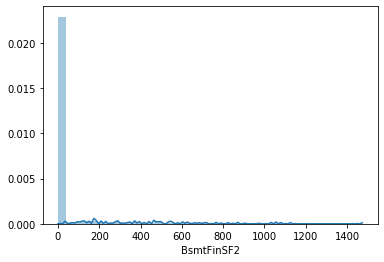

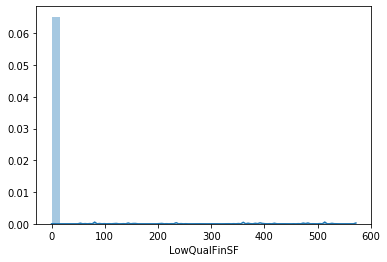

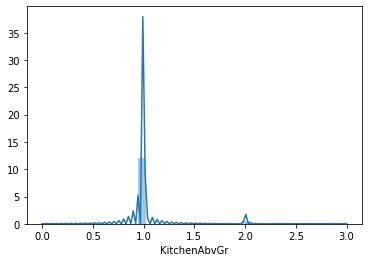

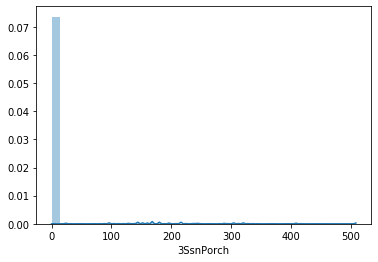

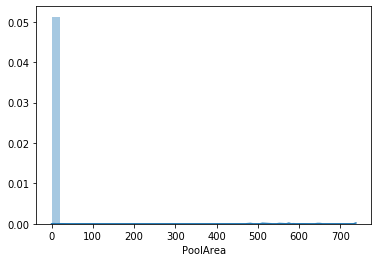

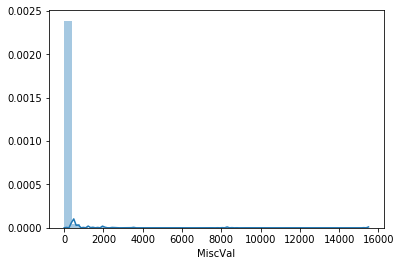

In [32]:
for k,v in dict_outliers.items():
    sns.distplot(train[k])
    plt.show()

Se puede apreciar en la esquina inferior derecha dos datos que indican un **AreaHabitable** muy grande, y sin embargo registran un bajo precio. Estos valores se consideran outliers. Por ello procederemos a eliminarlos.

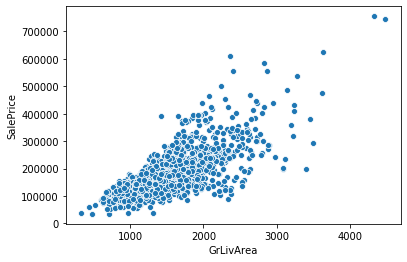

In [33]:
#Eliminamos los outliers acorde a las variables del gráfico
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

#Verificamos el gráfico nuevamente para confirmar que los outliers hayan sido eliminados
sns.scatterplot(x = train['GrLivArea'], y = train['SalePrice'])

Hay probabilidades de que otros valores atipicos existan en los datos de entrenamiento (si es que alli hubieran tambien outliers), sin embargo removerlos todos puede afectar negativamente nuestros modelos. Por ello vamos a permitir aquellos en los cuales los modelos son lo suficientemente robustos.

## Variable Objetivo

**Precio** es la variable que vamos a predecir. Asi que vamos a hacer un poco de analisis en esta variable primero.

In [34]:
from scipy.stats import norm, skew

Text(0.5, 1.0, 'Distribución del Precio')

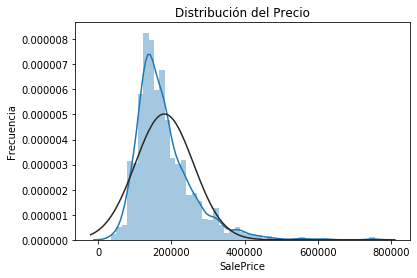

In [35]:
## Comparemos la distribución de Precio con una distribucion normal.
sns.distplot(train['SalePrice'], fit = norm)
plt.ylabel('Frecuencia')
plt.title('Distribución del Precio')

Se puede apreciar que los datos de la variable objetivo están inclinados a la izquierda. Sin embargo, los modelos lineales que veremos en la presente clase pueden optimizar su predición con datos distribuidos normalmente. Vamos a transformar los datos de esta variable para **aproximarlos a una distribución normal**.

 **Log-transformación de la variable objetivo**

Text(0.5, 1.0, 'Distribución del Precio Real Ajustado')

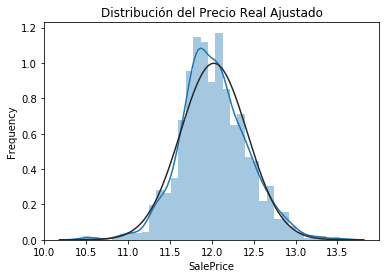

In [36]:
#Utilizamos la función log1p de la librería numpy que aplica la función log(1+x) a todos los elementos de la variable Precio
train["SalePrice"] = np.log1p(train["SalePrice"])

#Dibujamos la distribución actualizada de la variable Precio
sns.distplot(train['SalePrice'] , fit=norm);

plt.ylabel('Frequency')
plt.title('Distribución del Precio Real Ajustado')

**Vamos a revisar el archivo "DescripcionVariables.xlsx" el cual contiene un diccionario sobre el significado de las variables predictoras**

**Correlación de los Datos**


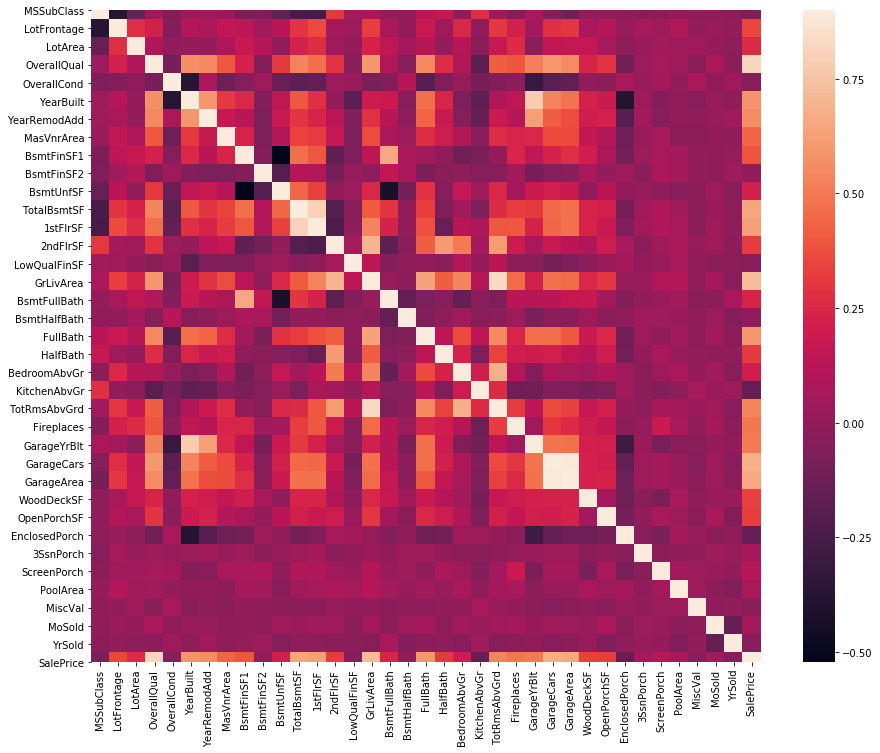

In [37]:
#Mapa de correlación para ver cómo las variables predictoras están correlacionadas con Precio
corrmat = train.corr()
plt.subplots(figsize=(15,12))
sns.heatmap(corrmat, vmax=0.9, square=True)

# Feature Engineering

**Transformando algunas variables númericas que realmente son categóricas**

In [38]:
#Cambiar las variables Año y Mes de venta de la casa a tipo entero
train['YrSold'] = train['YrSold'].astype(int)
train['MoSold'] = train['MoSold'].astype(int)

summit['YrSold'] = summit['YrSold'].astype(int)
summit['MoSold'] = summit['MoSold'].astype(int)

**Añadimos una variable importante**

Debido a que el área total es importante para predecir el precio de la casa, sumamos las tres variables **TotalSótano, 1erPiso, 2doPiso**

In [39]:
#Añadiendo tamaño total del area
train['TotalArea'] = train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']
summit['TotalArea'] = summit['TotalBsmtSF'] + summit['1stFlrSF'] + summit['2ndFlrSF']

**Detectamos el grado de asimetría de las variables predictoras** - Solo aquellas con data numérica

In [40]:
#Filtramos aquellas variables que tengan datos diferentes al tipo object, es decir numéricas
numeric_feats = train.dtypes[train.dtypes != "object"].index

#Aplicamos la función skew a las variables filtradas y mostramos el resultado ordenando de forma ascendente
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSesgo en características numéricas: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Sesgo en características numéricas: 



Skew
MiscVal        24.434913
PoolArea       15.932532
LotArea        12.560986
3SsnPorch      10.286510
LowQualFinSF    8.995688
KitchenAbvGr    4.480268
BsmtFinSF2      4.247550
ScreenPorch     4.114690
BsmtHalfBath    4.095895
EnclosedPorch   3.083987

In [41]:
skewness.Skew.unique()

array([24.43491309, 15.93253224, 12.56098556, 10.28650963,  8.99568802,
        4.48026755,  4.24754964,  4.11468994,  4.09589469,  3.08398693,
        2.69231316,  2.33742074,  1.69297614,  1.54421438,  1.4055634 ,
        1.00995129,  0.91995523,  0.88672314,  0.81212088,  0.8034937 ,
        0.76400241,  0.69032399,  0.67935111,  0.65982206,  0.63140912,
        0.58975093,  0.51117675,  0.2152106 ,  0.21210667,  0.20057935,
        0.1316124 ,  0.12145464,  0.09532172,  0.03123864, -0.34202466,
       -0.50132164, -0.61166451, -0.66649303])

### Tranformacion BoxCox

**Encodeamos rápidamente las variables categóricas**

In [42]:
cat_variables = [col for col in train.columns if train[col].dtype == 'object']

In [44]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for cat in cat_variables:
    le.fit(list(train[cat].values)+list(summit[cat].values))
    train[cat] = le.transform(train[cat])
    summit[cat] = le.transform(summit[cat])

In [45]:
train.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

# Modelos de Regresión

**Importamos librerías**

In [137]:
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score

from sklearn.model_selection import train_test_split

In [49]:
X = train.drop('SalePrice',axis=1)
y = train.SalePrice.values
X_train, X_test, y_train, y_test = train_test_split(X,y)

## Regresión Lineal

In [50]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [51]:
predicciones_lr = lr.predict(X_test)

In [60]:
print('Mi Error cuadratico medio es de: {:.8f}'.format(mean_squared_error(y_test, predicciones_lr)))
print('Mi RMSE es de: {:.8f}'.format(np.sqrt(mean_squared_error(y_test,predicciones_lr))))

Mi Error cuadratico medio es de: 0.01585973
Mi RMSE es de: 0.12593541


##  **Regresión Lasso**  : 

Este modelo es muy sensible a outliers, por ello necesitamos hacer más robusto el modelo a través del parámetro **Robustscaler** dentro de un pipeline

In [150]:
lasso = Lasso(alpha=0.0005, random_state=1)
lasso.fit(X_train, y_train)
predicciones_lasso = lasso.predict(X_test)

In [151]:
print('Mi Error cuadratico medio es de: {:.8f}'.format(mean_squared_error(y_test, predicciones_lasso)))
print('Mi RMSE es de: {:.8f}'.format(np.sqrt(mean_squared_error(y_test,predicciones_lasso))))

Mi Error cuadratico medio es de: 0.01524490
Mi RMSE es de: 0.12347025


## Regresión Ridge:

In [77]:
ridge = Ridge(alpha=1, solver = 'cholesky')
ridge.fit(X_train,y_train)
predicciones_ridge = ridge.predict(X_test)

In [78]:
print('Mi Error cuadratico medio es de: {:.8f}'.format(mean_squared_error(y_test, predicciones_ridge)))
print('Mi RMSE es de: {:.8f}'.format(np.sqrt(mean_squared_error(y_test,predicciones_ridge))))

Mi Error cuadratico medio es de: 0.01570416
Mi RMSE es de: 0.12531624


## **Regresión ElasticNet** :

In [140]:
elasticnet = ElasticNet(alpha=0.0005,l1_ratio=0.5)
elasticnet.fit(X_train, y_train)
predicciones_elasticnet = elasticnet.predict(X_test)

In [141]:
print('Mi Error cuadratico medio es de: {:.8f}'.format(mean_squared_error(y_test, predicciones_elasticnet)))
print('Mi RMSE es de: {:.8f}'.format(np.sqrt(mean_squared_error(y_test,predicciones_elasticnet))))

Mi Error cuadratico medio es de: 0.01547110
Mi RMSE es de: 0.12438286


## Descenso estocástico de la Gradiente

In [110]:
from sklearn.linear_model import SGDRegressor
sgd_r = SGDRegressor(max_iter = 1200000, penalty='elasticnet', eta0=0.01, tol=1e-3)
sgd_r.fit(X_train,y_train)

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1200000,
             n_iter_no_change=5, penalty='elasticnet', power_t=0.25,
             random_state=None, shuffle=True, tol=0.001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [111]:
predicciones_sgd = sgd_r.predict(X_test)

In [112]:
print('Mi Error cuadratico medio es de: {:.8f}'.format(mean_squared_error(y_test, predicciones_sgd)))
print('Mi RMSE es de: {:.8f}'.format(np.sqrt(mean_squared_error(y_test,predicciones_sgd))))

Mi Error cuadratico medio es de: 36992414110585151018006857258106880.00000000
Mi RMSE es de: 192334121025327040.00000000


## Regresión con Random Forests

In [160]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
rf = RandomForestRegressor(n_jobs=-1,max_depth=11,n_estimators=1500)
rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=11,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1500,
                      n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [162]:
predicciones_rf = rf.predict(X_test)

In [163]:
print('Mi Error cuadratico medio es de: {:.8f}'.format(mean_squared_error(y_test, predicciones_rf)))
print('Mi RMSE es de: {:.8f}'.format(np.sqrt(mean_squared_error(y_test,predicciones_rf))))

Mi Error cuadratico medio es de: 0.01691321
Mi RMSE es de: 0.13005078


## Pipelines!


## Mejorando y evaluando los modelos

In [146]:
#Creamos la función rmsle_cv para aplicar cross_val_score
def rmsle_cv(model,n_folds = 5):
    kf = KFold(n_folds, shuffle=True, random_state=1).get_n_splits(X_train.values)
    rmse= np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [149]:
lasso_pipeline = make_pipeline(RobustScaler(), Lasso(alpha=0.0005,random_state=1))
score = rmsle_cv(lasso_pipeline)
print("\nLasso score: {:.8f} ({:.8f})\n".format(score.mean(), score.std()))


Lasso score: 0.12703392 (0.00327329)



In [164]:
rf_pipeline = make_pipeline(RobustScaler(),RandomForestRegressor(n_jobs=-1,max_depth=11,n_estimators=1500))
score = rmsle_cv(rf_pipeline)

print("\RandomForestRegressor score: {:.8f} ({:.8f})\n".format(score.mean(), score.std()))


Lasso score: 0.13760619 (0.00659474)

